# Classifying movie reviews: a binary classification example


Two-class classification, or binary classification, is likely the most widely applied kind of machine learning problem. In this example, we
will learn to classify movie reviews into "positive" reviews and "negative" reviews, based on the text content of the reviews.

## The IMDb dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? Recall that you should never test a machine learning model on the same data that you used to
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and
what you actually care about is your model's performance on new data (since you already know the labels of your training data, you really don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between
your training samples and their targets. This would be completely useless for the task of predicting targets for data never seen before.


Just like the MNIST dataset, the IMDb dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words)
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

Let's start by importing the packages that we will need.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [ ]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words).
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

Let's verify the number of training and testing samples we have.

In [ ]:
len(train_data)

25000

In [ ]:
len(test_data)

25000

We can look at the first training sample as follows. As you see, it is a list of integer numbers (each number corresponds to a word).

In [ ]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

Below, we can see that the first training sample has a positive sentiment because its label is 1.

In [ ]:
train_labels[0]

1

The code below is a loop that goes through all integer numbers (word encodings) in the training data and returns the maximum value.
Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [ ]:
max([max(sequence) for sequence in train_data])

9999

Here's how you can quickly decode one of these reviews back to English words:

In [ ]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [ ]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparing the data


We cannot feed lists of integers into a neural network. They have all different lengths, but a neural network expects to process contiguous batches of data. Thus, we have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`,
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in
detail later in the course).
* We could *one-hot-encode* our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [ ]:
# FYI: Here is a toy example on how the above function works (I used the first 3 samples for demonstration)
seq = train_data[:3]
results_example = np.zeros((len(seq), 10000))
for i, sequence in enumerate(seq):
  print(i)                              # i is the index of the list
  print(sequence)                       # sequence is the actual list that contains word encodings
  results_example[i, sequence] = 1.
print(results_example)

0
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 501

Let's look at the first sample in the training set:

In [ ]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

You can see that it is one-hot-encoded; great!

Lastly, the train and test labels should be numpy arrays.
In this example, they alreay are. But, if they were not, or if we were not sure, we could vectorize our labels as follows:

In [ ]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [ ]:
np.shape(y_train)

(25000,)

Now our data are ready to be fed into a neural network.

## Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16,
activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension
in the representation space of the layer. Each such `Dense` layer with a `relu` activation implements
the following chain of tensor operations:

`output = relu( W . input + b )`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

We will discuss more about this in future classes.
In here, we are going to use:
two intermediate layers with 16 hidden units each,
and a third layer which will output the scalar prediction regarding the sentiment of the current review.
The intermediate layers will use `relu` as their "activation function",
and the final layer will use a sigmoid activation so as to output a probability
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive).
A `relu` (rectified linear unit) is a function meant to zero-out negative values,
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Keras implementation, very similar to the MNIST example you saw previously:

In [ ]:
model1 = models.Sequential()
model1.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))


Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss.
Crossentropy is usually the best choice when you
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance"
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will
also monitor accuracy during training.

In [ ]:
model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and
`accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer. This can be done by passing an optimizer class instance as the `optimizer` argument:

In [ ]:
# FYI only: Do not run this code
from tensorflow.keras import optimizers

model1.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by
setting apart 10,000 samples from the original training data:

In [ ]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples), in mini-batches of 512
samples. At the same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the
validation data as the `validation_data` argument:

In [ ]:
history_model1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 25ms/step - loss: 0.5327 - accuracy: 0.7765 - val_loss: 0.4101 - val_accuracy: 0.8625
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3253 - accuracy: 0.9019 - val_loss: 0.3314 - val_accuracy: 0.8758
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2333 - accuracy: 0.9274 - val_loss: 0.2893 - val_accuracy: 0.8863
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1804 - accuracy: 0.9425 - val_loss: 0.2943 - val_accuracy: 0.8818
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1430 - accuracy: 0.9561 - val_loss: 0.3137 - val_accuracy: 0.8808
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1158 - accuracy: 0.9659 - val_loss: 0.3198 - val_accuracy: 0.8795
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0977 - accuracy: 0.9719 - val_loss: 0.3486 - val_accuracy: 0.8759
Epoch 8/20
30

We achieved 99.9% accuracy on the training set and 86.6% accuracy on the validation set.
We can also evaluate this model (model1) on the test set.

In [ ]:
# Evaluate the model on the test set
results = model1.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.7365 - accuracy: 0.8543


We achieved an accuracy of 85.4% on the test set using model1.

We now take a closer look at the training and validation loss and accuracy over the 20 epochs.
Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data
about everything that happened during training. Let's take a look at it:

In [ ]:
history_dict = history_model1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's use Matplotlib to plot the
training and validation loss side by side, as well as the training and validation accuracy:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


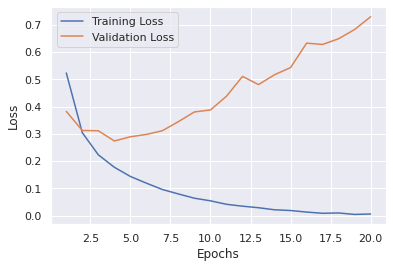

In [ ]:
# Seaborn is a Python data visualization library based on matplotlib.
# We use the default seaborn theme, scaling, and color palette.
import seaborn as sns
sns.set()

train_acc1  = history_model1.history['accuracy']
train_loss1 = history_model1.history['loss']
val_acc1  = history_model1.history['val_accuracy']
val_loss1 = history_model1.history['val_loss']

epochs = range(1, len(train_acc1) + 1)

plt.plot(epochs, train_loss1, label = 'Training Loss')
plt.plot(epochs, val_loss1, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

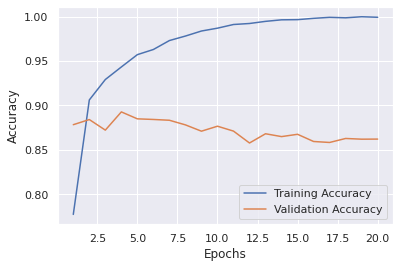

In [ ]:
plt.plot(epochs, train_acc1, label = 'Training Accuracy')
plt.plot(epochs, val_acc1, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


Note that your results may vary slightly from mine due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would
expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that
isn't the case for the validation loss: it seems to reach the minimum at the fourth epoch, then it begins to increase. This is an example of "overfitting." A model that performs better on the training data isn't necessarily a model that will do better on data it has never seen
before. After the fourth epoch, we are over-optimizing on the training data, and we
end up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after 4 epochs. In general, there is a range of techniques you can
leverage to mitigate overfitting, called Regularization Methods, which we explore below.

## Using a trained network to generate predictions on new data

After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive
by using the `predict` method:

In [ ]:
# Predict the probability of reviews being positive for the first 10 reviews in the test set
model1.predict(x_test[:10])

array([[1.8991351e-01],
       [9.9999821e-01],
       [9.9990976e-01],
       [6.7340422e-01],
       [9.9859685e-01],
       [9.9199229e-01],
       [9.9999988e-01],
       [2.1183936e-07],
       [9.9966431e-01],
       [9.9999988e-01]], dtype=float32)

As you can see, the network is very confident for some samples (0.99 or or 0.01, which correspond to a positive and a negative review, respectively ) but less confident for others (0.18 or 0.67).


# Regularization Methods

## 1. Early stopping

Let's train a new network from scratch for 4 epochs, then evaluate it on our test data. Let's call this model, "model2".

In [ ]:
model2 = models.Sequential()
model2.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_model2 = model2.fit(partial_x_train,
                            partial_y_train,
                            epochs=4,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/4
30/30 [==============================] - 1s 25ms/step - loss: 0.5438 - accuracy: 0.7844 - val_loss: 0.4245 - val_accuracy: 0.8623
Epoch 2/4
30/30 [==============================] - 1s 18ms/step - loss: 0.3455 - accuracy: 0.8959 - val_loss: 0.3309 - val_accuracy: 0.8834
Epoch 3/4
30/30 [==============================] - 1s 18ms/step - loss: 0.2540 - accuracy: 0.9193 - val_loss: 0.2900 - val_accuracy: 0.8902
Epoch 4/4
30/30 [==============================] - 1s 17ms/step - loss: 0.2014 - accuracy: 0.9352 - val_loss: 0.2760 - val_accuracy: 0.8915


We achieved 93.5% accuracy on the training set and 89.2% accuracy on the validation set.
We can also evaluate this model (model2) on the test set.

In [ ]:
# Evaluate the model on the test set
results = model2.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.2937 - accuracy: 0.8821


We achieved an accuracy of 88.2% on the test set using model2. That is already better than model1. The only thing we did was to stop training earlier (after 4 epochs rather than 20 epochs). This technique is called "Early Stopping" and it can help with overfitting.

## 2. Reducing the network's size

One of the simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of hidden units per layer). In deep learning, the number of learnable parameters in a model is
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any
generalization power.
Such a model would be useless for classifying
new movie reviews. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge
is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in
order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets
-- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You
will have to evaluate an array of different architectures (on your validation set, not on your test set) in order to find the
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the
validation loss.

Let's try this on our movie review classification network. Recall that our original model ("model1") had 2 layers with 16 neurons in each layer. Now, let's reduce the number of neurons (hidden units) from 16 to 4 and see how the model performs. Let's call this new model, "model3".

In [ ]:
model3 = models.Sequential()
model3.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
model3.add(layers.Dense(4, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_model3 = model3.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 24ms/step - loss: 0.6103 - accuracy: 0.7473 - val_loss: 0.5321 - val_accuracy: 0.8176
Epoch 2/20
30/30 [==============================] - 1s 17ms/step - loss: 0.4498 - accuracy: 0.8907 - val_loss: 0.4190 - val_accuracy: 0.8753
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3489 - accuracy: 0.9129 - val_loss: 0.3593 - val_accuracy: 0.8803
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2826 - accuracy: 0.9248 - val_loss: 0.3203 - val_accuracy: 0.8861
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2372 - accuracy: 0.9369 - val_loss: 0.2946 - val_accuracy: 0.8898
Epoch 6/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2031 - accuracy: 0.9449 - val_loss: 0.2839 - val_accuracy: 0.8914
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1764 - accuracy: 0.9512 - val_loss: 0.2821 - val_accuracy: 0.8875
Epoch 8/20
30

Let's plot the training and validation loss.

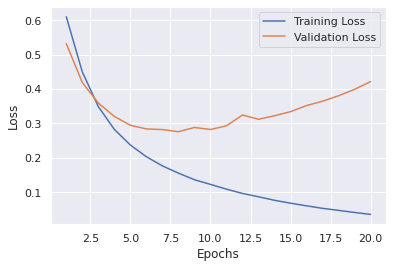

In [ ]:
train_acc3  = history_model3.history['accuracy']
train_loss3 = history_model3.history['loss']
val_acc3  = history_model3.history['val_accuracy']
val_loss3 = history_model3.history['val_loss']

epochs = range(1, len(train_acc3) + 1)

plt.plot(epochs, train_loss3, label = 'Training Loss')
plt.plot(epochs, val_loss3, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Now, let's plot the loss of the simpler model and the original model on the same graph so that we can easily compare them.

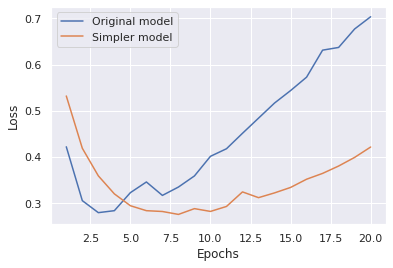

In [ ]:
plt.plot(epochs, val_loss1, label = 'Original model')
plt.plot(epochs, val_loss3, label = 'Simpler model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

As you can see, the smaller network starts overfitting after 10 epochs (rather than after 4 epochs) and its performance
degrades much more slowly once it starts overfitting.

Let's evalute the performance of model3 on test set.

In [ ]:
# Evaluate the model on the test set
results = model3.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.4648 - accuracy: 0.8564


The model with reduced size (4 neurons per layer) achieves an accuracy of 85.6% on the test set, which is slightly better than the original model with 16 neurons per layer.
(Note: each time we run the code, we will obtain a slightly different accuracy due to random initialization of the network parameters.)  

For comparison, let's also build a model with 512 neurons per layer. This will give the network a lot of memorization capacity, thus it will likely overfit. Let's call this bigger model, "model4".

In [ ]:
model4 = models.Sequential()
model4.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_model4 = model4.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 32ms/step - loss: 0.5491 - accuracy: 0.7479 - val_loss: 0.3104 - val_accuracy: 0.8810
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.2590 - accuracy: 0.8999 - val_loss: 0.2743 - val_accuracy: 0.8875
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1690 - accuracy: 0.9343 - val_loss: 0.2798 - val_accuracy: 0.8860
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0807 - accuracy: 0.9726 - val_loss: 0.3952 - val_accuracy: 0.8732
Epoch 5/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1122 - accuracy: 0.9755 - val_loss: 0.3173 - val_accuracy: 0.8908
Epoch 6/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0059 - accuracy: 0.9993 - val_loss: 0.4734 - val_accuracy: 0.8903
Epoch 7/20
30/30 [==============================] - 1s 23ms/step - loss: 6.4434e-04 - accuracy: 1.0000 - val_loss: 0.5840 - val_accuracy: 0.8880
Epoch 8/2

As you can see, after only 7 epochs, the training accuracy reached to 100%, which means that this bigger model has been able to memorize all training examples. But, it may not work well on new data.

Let's plot the training and validation loss.

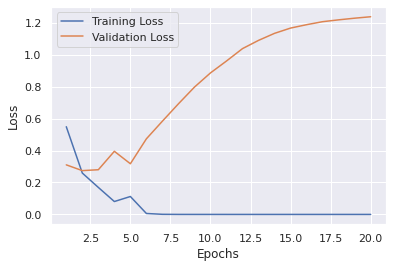

In [ ]:
train_acc4  = history_model4.history['accuracy']
train_loss4 = history_model4.history['loss']
val_acc4  = history_model4.history['val_accuracy']
val_loss4 = history_model4.history['val_loss']

epochs = range(1, len(train_acc4) + 1)

plt.plot(epochs, train_loss4, label = 'Training Loss')
plt.plot(epochs, val_loss4, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Now, let's compare the loss of this model against the original model.

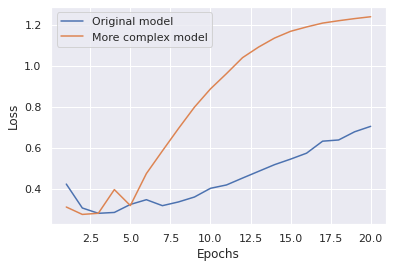

In [ ]:
plt.plot(epochs, val_loss1, label = 'Original model')
plt.plot(epochs, val_loss4, label = 'More complex model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

As you can see, the original model performs better than the more complex model with many more hidden units. The bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large
difference between the training and validation loss).

## 3. Weight regularization

You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called
"weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different
name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight
regularization to our movie review classification network:

In [ ]:
from tensorflow.keras import regularizers

model5 = models.Sequential()
model5.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
model5.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

Note that because this penalty is _only added at training time_, the loss for this network will be higher at training
than at test time.

In [ ]:
model5.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

In [ ]:
history_model5 = model5.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 40ms/step - loss: 0.5567 - acc: 0.7881 - val_loss: 0.4236 - val_acc: 0.8752
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3567 - acc: 0.8986 - val_loss: 0.3720 - val_acc: 0.8724
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2843 - acc: 0.9198 - val_loss: 0.3305 - val_acc: 0.8885
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2493 - acc: 0.9305 - val_loss: 0.3302 - val_acc: 0.8876
Epoch 5/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2269 - acc: 0.9427 - val_loss: 0.3364 - val_acc: 0.8844
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2099 - acc: 0.9492 - val_loss: 0.3424 - val_acc: 0.8807
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1980 - acc: 0.9537 - val_loss: 0.4031 - val_acc: 0.8625
Epoch 8/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1900 - a

In [ ]:
history_model5.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Let's plot the training and validation loss.

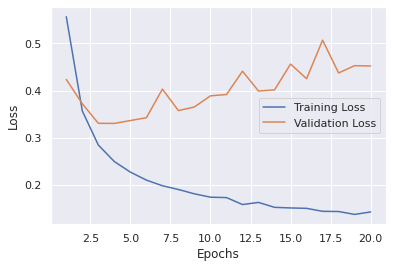

In [ ]:
train_acc5  = history_model5.history['acc']
train_loss5 = history_model5.history['loss']
val_acc5  = history_model5.history['val_acc']
val_loss5 = history_model5.history['val_loss']

epochs = range(1, len(train_acc5) + 1)

plt.plot(epochs, train_loss5, label = 'Training Loss')
plt.plot(epochs, val_loss5, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Now, let's compare the loss of this model against the original model.

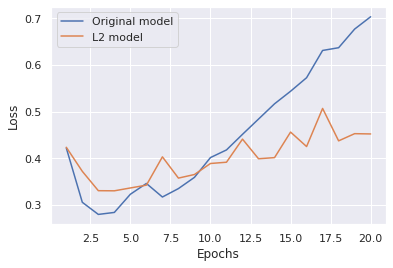

In [ ]:
plt.plot(epochs, val_loss1, label = 'Original model')
plt.plot(epochs, val_loss5, label = 'L2 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The L2-regularized model is much more resistant to overfitting - the validation loss starts to increase at a much slower rate.


## Dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.
Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of output features of the layer during training.
Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5,
1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out. At test
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to
balance for the fact that more units are active than at training time.


This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance (coincidence) patterns that are not significant (what
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present.

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it.

Let's add two `Dropout` layers in our IMDb example to see how well they do at reducing overfitting:

In [ ]:
model6 = models.Sequential()
model6.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(16, activation='relu'))
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(1, activation='sigmoid'))

The 0.5 indicates a 50% probability of dropping out a
unit. You can try different values and see what performs best.

In [ ]:
model6.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

In [ ]:
history_model6 = model6.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6392 - acc: 0.6375 - val_loss: 0.5370 - val_acc: 0.8186
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.5263 - acc: 0.7730 - val_loss: 0.4321 - val_acc: 0.8587
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.4400 - acc: 0.8269 - val_loss: 0.3599 - val_acc: 0.8809
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3697 - acc: 0.8637 - val_loss: 0.3129 - val_acc: 0.8871
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3217 - acc: 0.8861 - val_loss: 0.3043 - val_acc: 0.8864
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2791 - acc: 0.9063 - val_loss: 0.2829 - val_acc: 0.8862
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2410 - acc: 0.9212 - val_loss: 0.2872 - val_acc: 0.8886
Epoch 8/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2174 - a

In [ ]:
history_model6.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Let's plot the training and validation loss.

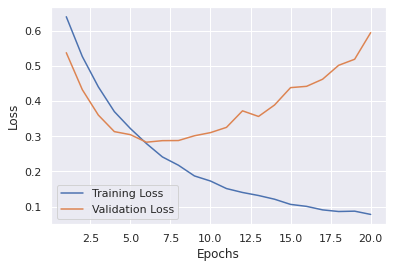

In [ ]:
train_acc6  = history_model6.history['acc']
train_loss6 = history_model6.history['loss']
val_acc6  = history_model6.history['val_acc']
val_loss6 = history_model6.history['val_loss']

epochs = range(1, len(train_acc6) + 1)

plt.plot(epochs, train_loss6, label = 'Training Loss')
plt.plot(epochs, val_loss6, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Now, let's compare the loss of this model against the original model.

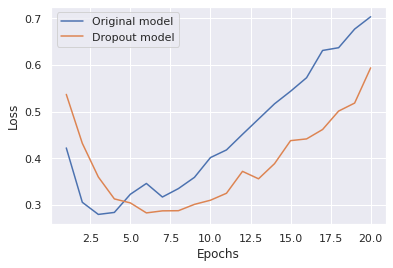

In [ ]:
plt.plot(epochs, val_loss1, label = 'Original model')
plt.plot(epochs, val_loss6, label = 'Dropout model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The Dropout model is better than the original model and prevents overfitting to some extent.

## Multiple regularization methods

We can also combine multiple regularization methods. Let's build a new model with both L2 and Dropout.

In [ ]:
model7 = models.Sequential()
model7.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model7.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

In [ ]:
history_model7 = model7.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 27ms/step - loss: 0.6649 - acc: 0.6364 - val_loss: 0.5555 - val_acc: 0.8415
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.5400 - acc: 0.7669 - val_loss: 0.4304 - val_acc: 0.8711
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.4541 - acc: 0.8261 - val_loss: 0.3679 - val_acc: 0.8788
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3966 - acc: 0.8625 - val_loss: 0.3401 - val_acc: 0.8879
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3510 - acc: 0.8857 - val_loss: 0.3228 - val_acc: 0.8893
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3253 - acc: 0.9002 - val_loss: 0.3228 - val_acc: 0.8883
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2986 - acc: 0.9120 - val_loss: 0.3412 - val_acc: 0.8822
Epoch 8/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2808 - a

Now, let's compare the validation loss of the original model, L2 model, Dropout model, and L2 & Dropout model on the same graph.

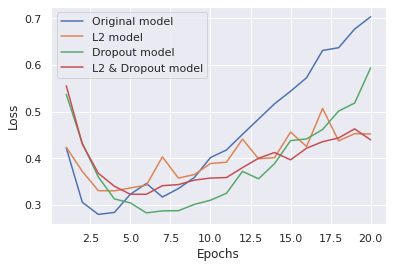

In [ ]:
train_acc7  = history_model7.history['acc']
train_loss7 = history_model7.history['loss']
val_acc7  = history_model7.history['val_acc']
val_loss7 = history_model7.history['val_loss']

epochs = range(1, len(train_acc7) + 1)

plt.plot(epochs, val_loss1, label = 'Original model')
plt.plot(epochs, val_loss5, label = 'L2 model')
plt.plot(epochs, val_loss6, label = 'Dropout model')
plt.plot(epochs, val_loss7, label = 'L2 & Dropout model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Conclusions


Here's what you should take away from this example:

* There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural
network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other encoding options too.
* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you will
likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a `Dense` layer with 1 unit and a `sigmoid` activation,
i.e. the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output, on a binary classification problem, the loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry
about.
* As they get better on their training data, neural networks eventually start _overfitting_ and end up obtaining increasingly worse results on data
never-seen-before. Make sure to always monitor performance on data that is outside of the training set (e.g., validation set).
* The most common ways to prevent overfitting in neural networks are

> * Getting more training data, if possible
* Early stopping
* Reducing the capacity of the network
* Adding weight regularization
* Adding dropout



